In [27]:
import pandas as pd
import numpy as np

In [28]:
df = pd.read_csv('reddit_sentiment_data_models.csv')
df.shape

(55546, 12)

### Derive indicators
* Engagement ratio = Number of comments / Score

In [29]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Set multiple index for date and stock
df = df.set_index(['date', 'stock'])

# Create total sentiment for each model
models = ['stanza', 'roberta', 'longformer']
for model in models:
    title_col = f'title_score_{model}'
    body_col = f'body_score_{model}'
    if title_col in df.columns and body_col in df.columns:
        df[f'total_sentiment_{model}'] = df[title_col] + df[body_col]
    else:
        print(f"Warning: Missing columns for {model} model")

# Aggregate by date and stock (sum all posts for same stock on same day)
df = df.groupby(['date', 'stock']).agg('sum')

# Set score to 1 if it is less than 1 to avoid division by zero
df['score'] = np.where(df['score'] < 1, 1, df['score'])

# Add column engagement_ratio
df['engagement_ratio'] = df['comms_num'] / df['score']

# Convert back to proper index format
df = df.reset_index()
df = df.set_index(['date', 'stock'])

print("Available sentiment columns:")
sentiment_cols = [col for col in df.columns if 'total_sentiment' in col]
print(sentiment_cols)

Available sentiment columns:
['total_sentiment_stanza', 'total_sentiment_roberta', 'total_sentiment_longformer']


### Aggregate Monthly and calculate average sentiment for the month
#### Filter strategy
* Top 5 "Sentiment" stocks (Not good in return (22-Apr done)
* Top 5 "Engagement" stocks (Return similar to QQQ in the beginning, then became loss) (27-Apr done)

In [21]:
df.head()

title  score  \
date       stock                                                             
2021-01-28 AA                       RH unable to tradeAA pre market     11   
           AAL    AAL, AMC, EXPR, GME, NOK - The Ride to the Moo...    972   
           ADMA                                                Adma      2   
           AG     Once you're done with GME - $AG and $SLV, the ...      1   
           AGI                            Charitably-Minded Autists    282   

                  comms_num  \
date       stock              
2021-01-28 AA             5   
           AAL          218   
           ADMA           0   
           AG            16   
           AGI           42   

                                                               body  \
date       stock                                                      
2021-01-28 AA     Anyone else unable to trade in Robinhood, GME,...   
           AAL    Guys it’s simple.  If you’re selling YOURE hur...   
           ADMA         ADMA only US plasma publicly traded company   
           AG     You guys are champs. GME... who would have tho...   
           AGI    Probably doesn't belong here, but I honestly d...   

                  title_score_stanza  body_score_stanza  title_score_roberta  \
date       stock                                                               
2021-01-28 AA                    2.0                  2                    1   
           AAL                  13.0                  6                   17   
           ADMA                  1.0                  1                    1   
           AG                    1.0                  1                    1   
           AGI                   1.0                  1                    0   

                  body_score_roberta  title_score_longformer  \
date       stock                                               
2021-01-28 AA                      3                       6   
           AAL                     5                      23   
           ADMA                    1                       2   
           AG                      0                       0   
           AGI                     1                       2   

                  body_score_longformer  total_sentiment_stanza  \
date       stock                                                  
2021-01-28 AA                         0                     4.0   
           AAL                       26                    19.0   
           ADMA                       2                     2.0   
           AG                         0                     2.0   
           AGI                        0                     2.0   

                  total_sentiment_roberta  total_sentiment_longformer  \
date       stock                                                        
2021-01-28 AA                           4                           6   
           AAL                         22                          49   
           ADMA                         2                           4   
           AG                           1                           0   
           AGI                          1                           2   

                  engagement_ratio  
date       stock                    
2021-01-28 AA             0.454545  
           AAL            0.224280  
           ADMA           0.000000  
           AG            16.000000  
           AGI            0.148936

In [30]:
# Function to filter strategy for any indicator with historical data validation
def filter_strategy(df, indicator, available_stocks=None):
    # Aggregate monthly using the specified indicator
    df_agg = (df.reset_index('stock').groupby([pd.Grouper(freq='ME'), 'stock'])[[indicator]].mean())
    
    # Rank based on specific indicator
    df_agg['rank'] = (df_agg.groupby(level=0)[indicator].transform(lambda x: x.rank(ascending=False).astype(int)))
    
    # If we have available stocks list, ensure we get exactly 5 valid stocks
    if available_stocks is not None:
        df_final = pd.DataFrame()
        
        for date in df_agg.index.get_level_values(0).unique():
            month_data = df_agg.xs(date, level=0).sort_values('rank')
            selected_stocks = []
            
            # Try to get 5 stocks with historical data
            for _, row in month_data.iterrows():
                stock = row.name  # stock is the index name
                if stock in available_stocks and len(selected_stocks) < 5:
                    selected_stocks.append(stock)
            
            # If we couldn't get 5 stocks, fill with best available
            if len(selected_stocks) < 5:
                remaining_stocks = [s for s in month_data.index if s in available_stocks and s not in selected_stocks]
                selected_stocks.extend(remaining_stocks[:5-len(selected_stocks)])
            
            # Create dataframe for this month with selected stocks
            if selected_stocks:
                month_filtered = month_data.loc[selected_stocks].copy()
                month_filtered['rank'] = range(1, len(month_filtered) + 1)  # Re-rank from 1 to N
                month_filtered = month_filtered.reset_index()
                month_filtered['date'] = date
                month_filtered = month_filtered.set_index(['date', 'stock'])
                df_final = pd.concat([df_final, month_filtered])
        
        df_filtered = df_final
    else:
        # Original logic - filter out top 5 ranking without validation
        df_filtered = df_agg[df_agg['rank'] <= 5].copy()
    
    # Adjust date to be the first day of the month
    df_filtered = df_filtered.reset_index('stock')
    df_filtered.index = df_filtered.index + pd.DateOffset(1)
    df_filtered = df_filtered.reset_index().set_index(['date', 'stock'])
    
    return df_filtered

# Test with one model first
indicator = 'total_sentiment_roberta'
if indicator in df.columns:
    df_filtered_roberta = filter_strategy(df, indicator)
    print(f"Filtered data shape for {indicator}: {df_filtered_roberta.shape}")
else:
    print(f"Column {indicator} not found in dataframe")

Filtered data shape for total_sentiment_roberta: (40, 2)


### Extract the stocks to form portfolios with at the start of each new month
* Create a dictionary containing start of month and corresponded selected stocks.

In [31]:
# Create portfolios for four different indicators across all three sentiment models
models = ['stanza', 'roberta', 'longformer']
indicators = {
    'score': 'score',  # Most upvotes
    'comments': 'comms_num',  # Most number of comments
    'engagement': 'engagement_ratio',  # Engagement ratio
    'total_sentiment_stanza': 'total_sentiment_stanza',  # Sentiment for Stanza
    'total_sentiment_roberta': 'total_sentiment_roberta',  # Sentiment for RoBERTa
    'total_sentiment_longformer': 'total_sentiment_longformer'  # Sentiment for Longformer
}

portfolios = {}
all_stocks = set()

# First pass: collect all unique stocks without validation for each indicator
print("First pass: Collecting all potential stocks for each indicator...")
for indicator_name, indicator_col in indicators.items():
    if indicator_col in df.columns:
        # Filter strategy for this indicator
        df_filtered = filter_strategy(df, indicator_col)
        
        # Extract all stocks mentioned
        dates = df_filtered.index.get_level_values('date').unique().to_list()
        for date in dates:
            stocks = df_filtered.xs(date, level=0).index.tolist()
            all_stocks.update(stocks)
        
        print(f"{indicator_name}: {len(dates)} months, {len(df_filtered.index.get_level_values('stock').unique())} unique stocks")
    else:
        print(f"Warning: {indicator_col} not found in data")

print(f"\nTotal unique stocks across all indicators: {len(all_stocks)}")

# Store temporary portfolios for later validation
portfolios_temp = {}
for indicator_name, indicator_col in indicators.items():
    if indicator_col in df.columns:
        df_filtered = filter_strategy(df, indicator_col)
        dates = df_filtered.index.get_level_values('date').unique().to_list()
        fixed_dates = {}
        for date in dates:
            stocks = df_filtered.xs(date, level=0).index.tolist()
            fixed_dates[date.strftime('%Y-%m-%d')] = stocks
        
        portfolios_temp[indicator_name] = fixed_dates

print("Sample portfolio for score indicator:")
if 'score' in portfolios_temp:
    sample_dates = list(portfolios_temp['score'].keys())[:3]
    for date in sample_dates:
        print(f"  {date}: {portfolios_temp['score'][date]}")

First pass: Collecting all potential stocks for each indicator...
score: 8 months, 30 unique stocks
comments: 8 months, 24 unique stocks
engagement: 8 months, 39 unique stocks
total_sentiment_stanza: 8 months, 18 unique stocks
total_sentiment_roberta: 8 months, 20 unique stocks
total_sentiment_longformer: 8 months, 18 unique stocks

Total unique stocks across all indicators: 93
Sample portfolio for score indicator:
  2021-02-01: ['AMC', 'BB', 'EDIT', 'GME', 'YOU']
  2021-03-01: ['AMC', 'DD', 'EL', 'GME', 'GMED']
  2021-04-01: ['DD', 'GME', 'OC', 'RARE', 'SIG']


### Download the fresh stock prices for only selected/shortlisted stocks
* Calculate cumulative log returns (Time-additive)

In [32]:
# List all unique stocks across all models
stock_list = list(all_stocks)
print(f"Loading historical data for {len(stock_list)} stocks")
print(f"Sample stocks: {stock_list[:10]}")

Loading historical data for 93 stocks
Sample stocks: ['OC', 'FOUR', 'SOL', 'ROOT', 'UWMC', 'SF', 'MVIS', 'DMA', 'SD', 'BB']


In [33]:
# Set date range
start = pd.to_datetime("2021-03-01").strftime('%Y-%m-%d')
end = pd.to_datetime("2021-08-31").strftime('%Y-%m-%d')

# Load historical stock data
df_all = pd.DataFrame()
missing_stocks = []
available_stocks = []

for ticker in stock_list:
    try:
        # Read CSV, skip first 3 rows (header info), use manual column names
        df_temp = pd.read_csv(f'stock_historical_prices_2019-2024/{ticker}.csv', 
                             skiprows=3, 
                             names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        df_temp = df_temp.set_index('Date')[start:end]['Close'].to_frame(ticker)
        
        # Check if we have valid data (not all NaN)
        if not df_temp[ticker].isna().all():
            available_stocks.append(ticker)
            df_all = pd.concat([df_all, df_temp], axis=1)
        else:
            print(f'Warning: {ticker} has no valid data in date range')
            missing_stocks.append(ticker)
    except Exception as e:
        print(f'Error reading {ticker}.csv: {e}')
        missing_stocks.append(ticker)

# Calculate log returns
df_return = np.log(df_all.astype('float64')).diff().dropna(how='all')

print(f"Total stocks attempted: {len(stock_list)}")
print(f"Successfully loaded with valid data: {len(available_stocks)}")
print(f"Missing or invalid stock files: {len(missing_stocks)}")
print(f"Return data shape: {df_return.shape}")
print(f"Date range: {df_return.index.min()} to {df_return.index.max()}")

# Now recreate portfolios with validation using available stocks
print(f"\nRecreating portfolios with validation using {len(available_stocks)} available stocks...")
portfolios = {}

for model in models:
    indicator = f'total_sentiment_{model}'
    if indicator in df.columns:
        # Filter strategy for this model WITH validation
        df_filtered = filter_strategy(df, indicator, available_stocks=set(available_stocks))
        
        # Extract portfolio dates and stocks
        dates = df_filtered.index.get_level_values('date').unique().to_list()
        fixed_dates = {}
        stocks_per_month = []
        
        for date in dates:
            stocks = df_filtered.xs(date, level=0).index.tolist()
            fixed_dates[date.strftime('%Y-%m-%d')] = stocks
            stocks_per_month.append(len(stocks))
        
        portfolios[model] = fixed_dates
        print(f"{model.capitalize()} model: {len(dates)} months, avg {np.mean(stocks_per_month):.1f} stocks per month")
        
        # Check if we consistently get 5 stocks
        if len(set(stocks_per_month)) == 1 and stocks_per_month[0] == 5:
            print(f"  ✓ Successfully gets exactly 5 stocks every month")
        else:
            print(f"  ⚠ Variable stocks per month: {set(stocks_per_month)}")
    else:
        print(f"Warning: {indicator} not found in data")

print("Sample validated portfolio for roberta model:")
if 'roberta' in portfolios:
    sample_dates = list(portfolios['roberta'].keys())[:3]
    for date in sample_dates:
        stocks = portfolios['roberta'][date]
        print(f"  {date}: {stocks} ({len(stocks)} stocks)")

Total stocks attempted: 93
Successfully loaded with valid data: 84
Missing or invalid stock files: 9
Return data shape: (128, 84)
Date range: 2021-03-02 00:00:00 to 2021-08-31 00:00:00

Recreating portfolios with validation using 84 available stocks...
Stanza model: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
Roberta model: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
Longformer model: 8 months, avg 5.0 stocks per month
  ✓ Successfully gets exactly 5 stocks every month
Sample validated portfolio for roberta model:
  2021-02-01: ['GME', 'AMC', 'BB', 'NOK', 'RH'] (5 stocks)
  2021-03-01: ['GME', 'AMC', 'DD', 'BB', 'RH'] (5 stocks)
  2021-04-01: ['GME', 'DD', 'RKT', 'AMC', 'UWMC'] (5 stocks)


In [34]:
# DEBUGGING: Show detailed portfolio composition for each model and month
print("="*80)
print("DETAILED PORTFOLIO COMPOSITION DEBUG")
print("="*80)

for model in models:
    if model in portfolios:
        print(f"\n{model.upper()} MODEL PORTFOLIOS:")
        print("-" * 60)
        
        for date_str, stocks in portfolios[model].items():
            # Check which stocks are available in historical data
            available = [s for s in stocks if s in available_stocks]
            missing = [s for s in stocks if s not in available_stocks]
            
            print(f"{date_str}: {len(stocks)} selected, {len(available)} available")
            print(f"  Available: {available}")
            if missing:
                print(f"  Missing:   {missing}")
            print()
    else:
        print(f"\n{model.upper()} MODEL: No portfolio data available")

print("="*80)
print(f"SUMMARY:")
print(f"Total available stocks with historical data: {len(available_stocks)}")
print(f"Total missing stocks: {len(missing_stocks)}")
print("="*80)

DETAILED PORTFOLIO COMPOSITION DEBUG

STANZA MODEL PORTFOLIOS:
------------------------------------------------------------
2021-02-01: 5 selected, 5 available
  Available: ['GME', 'AMC', 'BB', 'NOK', 'RH']

2021-03-01: 5 selected, 5 available
  Available: ['GME', 'AMC', 'DD', 'RH', 'BB']

2021-04-01: 5 selected, 5 available
  Available: ['GME', 'DD', 'RKT', 'AMC', 'UWMC']

2021-05-01: 5 selected, 5 available
  Available: ['DD', 'GME', 'MVIS', 'SO', 'CLOV']

2021-06-01: 5 selected, 5 available
  Available: ['DD', 'GME', 'AMC', 'PLTR', 'UWMC']

2021-07-01: 5 selected, 5 available
  Available: ['DD', 'AMC', 'GME', 'CLOV', 'CLF']

2021-08-01: 5 selected, 5 available
  Available: ['DD', 'AMC', 'COO', 'SPCE', 'GME']

2021-09-01: 5 selected, 5 available
  Available: ['DD', 'AMD', 'IR', 'CNK', 'PLTR']


ROBERTA MODEL PORTFOLIOS:
------------------------------------------------------------
2021-02-01: 5 selected, 5 available
  Available: ['GME', 'AMC', 'BB', 'NOK', 'RH']

2021-03-01: 5 selecte

In [193]:
# Calculate log return of each stocks
# df_return = np.log(df_price['Close']).diff().dropna(how='all')

In [35]:
# Calculate portfolio returns for all three models
portfolio_returns = {}

for model in models:
    if model in portfolios:
        print(f"Calculating returns for {model} model...")
        df_portfolio = pd.DataFrame()
        
        for start_date in portfolios[model].keys():
            # Find next month end as end date
            end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
            tickers = portfolios[model][start_date]
            
            # Filter tickers that exist in our return data
            available_tickers = [t for t in tickers if t in df_return.columns]
            
            if available_tickers:
                # Calculate equal-weighted portfolio return for this period
                df_temp = df_return[start_date:end_date][available_tickers].mean(axis=1).to_frame(f'portfolio_return_{model}')
                df_portfolio = pd.concat([df_portfolio, df_temp], axis=0)
            else:
                print(f"Warning: No available tickers for {start_date} in {model} model")
        
        df_portfolio.index = pd.to_datetime(df_portfolio.index)
        portfolio_returns[model] = df_portfolio
        print(f"  {model} portfolio shape: {df_portfolio.shape}")

print(f"\nSuccessfully created portfolios for {len(portfolio_returns)} models")

Calculating returns for stanza model...
  stanza portfolio shape: (128, 1)
Calculating returns for roberta model...
  roberta portfolio shape: (128, 1)
Calculating returns for longformer model...
  longformer portfolio shape: (128, 1)

Successfully created portfolios for 3 models


### Download prices of NASDAQ / QQQ and calculate returns to compare to our strategy


PERFORMANCE ANALYSIS

 DAILY OUTPERFORMANCE vs QQQ:
----------------------------------------
Stanza Strategy     :   56 /  128 days ( 43.8%)
Roberta Strategy    :   57 /  128 days ( 44.5%)
Longformer Strategy :   55 /  128 days ( 43.0%)


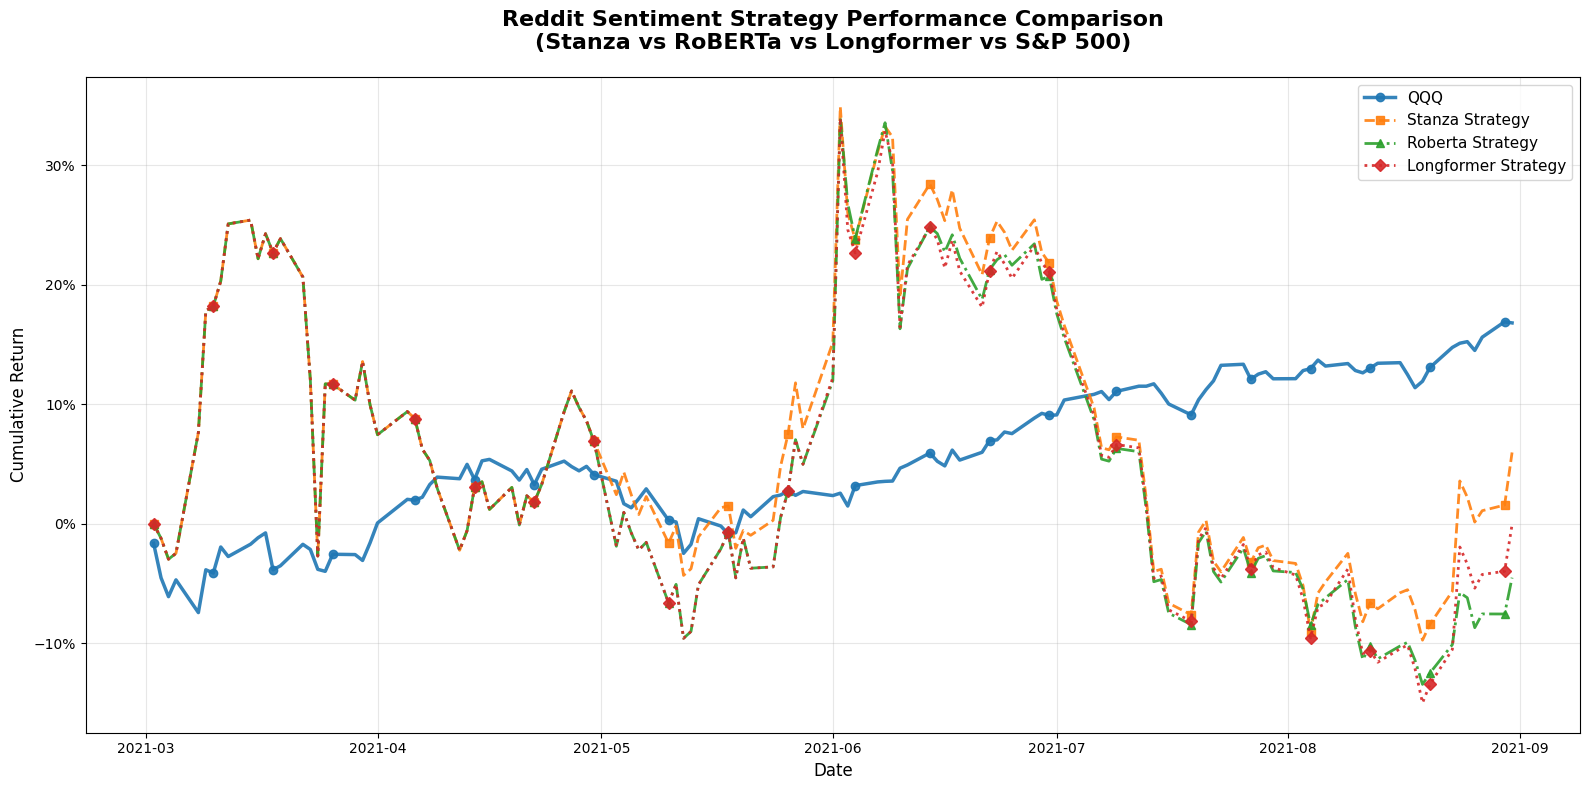

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Define styles for each strategy
line_styles = ['-', '--', '-.', ':']   # Different dash patterns
markers = ['o', 's', '^', 'D']         # Circle, square, triangle, diamond
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Same colors you had

plt.figure(figsize=(16, 8))

# Plot each strategy with distinct style
for i, column in enumerate(portfolio_cumulative_return.columns):
    plt.plot(
        portfolio_cumulative_return.index,
        portfolio_cumulative_return[column],
        label=column,
        linewidth=2.5 if i == 0 else 2,        # Slightly thicker for first curve
        color=colors[i % len(colors)],
        linestyle=line_styles[i % len(line_styles)],
        marker=markers[i % len(markers)],
        markevery=max(len(portfolio_cumulative_return) // 20, 1),  # Space markers
        alpha=0.9
    )

plt.title(
    'Reddit Sentiment Strategy Performance Comparison\n(Stanza vs RoBERTa vs Longformer vs S&P 500)',
    fontsize=16, fontweight='bold', pad=20
)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()


# Calculate outperformance metrics
print("\n" + "="*80)
print("PERFORMANCE ANALYSIS")
print("="*80)

# Outperformance analysis
print(f"\n DAILY OUTPERFORMANCE vs {benchmark_name}:")
print("-" * 40)
benchmark_col = df_all_returns_filled.columns[0]

for column in df_all_returns_filled.columns[1:]:  # Skip benchmark
    # Only compare on days where strategy has valid data
    valid_days = df_all_returns[column].notna()
    
    if valid_days.sum() > 0:
        portfolio_returns = df_all_returns_filled.loc[valid_days, column]
        benchmark_returns = df_all_returns_filled.loc[valid_days, benchmark_col]
        
        outperformed_days = (portfolio_returns > benchmark_returns).sum()
        total_days = len(portfolio_returns)
        outperformance_pct = (outperformed_days / total_days) * 100
        
        print(f"{column:<20}: {outperformed_days:4d} / {total_days:4d} days ({outperformance_pct:5.1f}%)")
    else:
        print(f"{column:<20}: No valid data for comparison")

print("="*80)

plt.show()